<a href="https://colab.research.google.com/github/DamodaraBarbosa/eleicoes_ceara_2022/blob/main/municipios_ceara_eleicao_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importando bibliotecas

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from yellowbrick.cluster import KElbowVisualizer
from sklearn.decomposition import PCA
from matplotlib.ticker import MaxNLocator
from sklearn.cluster import KMeans

# 1. Carregando dados

In [2]:
# Dados referentes aos cargos disputados no estado do Ceará:

votacao_ce = pd.read_csv(
    '/content/drive/MyDrive/eleicoes_ceara_2022/votacao_secao_2022_CE_tratado.csv',
    encoding= 'latin-1', sep= ','
)

# Visualização das primeiras observações do dataframe:

votacao_ce.head()

,nm_municipio,nr_turno,nr_zona,nr_secao,ds_cargo,nr_votavel,nm_votavel,qt_votos
0,FORTALEZA,1,94,6,DEPUTADO FEDERAL,4444,HEITOR RODRIGO PEREIRA FREIRE,4
1,RUSSAS,1,9,266,DEPUTADO FEDERAL,4444,HEITOR RODRIGO PEREIRA FREIRE,13
2,PARAIPABA,1,109,119,DEPUTADO FEDERAL,4444,HEITOR RODRIGO PEREIRA FREIRE,3
3,ITAPIPOCA,1,17,25,DEPUTADO FEDERAL,4444,HEITOR RODRIGO PEREIRA FREIRE,2
4,SABOEIRO,1,43,228,DEPUTADO FEDERAL,4444,HEITOR RODRIGO PEREIRA FREIRE,4


In [3]:
# Dados referetes ao cargo de presidente da república:

presidente = pd.read_csv(
    '/content/drive/MyDrive/eleicoes_ceara_2022/votacao_secao_2022_BR.csv',
    encoding= 'latin-1', sep= ';'
)

# Buscam-se os dados referentes apenas ao estado do Ceará:

presidente_ce = presidente.query('SG_UF == "CE"')[['NM_MUNICIPIO', 'DS_CARGO', 'NR_TURNO', 'NR_VOTAVEL', 'NM_VOTAVEL', 'QT_VOTOS']]

# Visualização das primeiras observações do dataframe:

presidente_ce.head()

,NM_MUNICIPIO,DS_CARGO,NR_TURNO,NR_VOTAVEL,NM_VOTAVEL,QT_VOTOS
7,JUCÁS,PRESIDENTE,1,13,LUIZ INÁCIO LULA DA SILVA,212
57,GRANJA,PRESIDENTE,1,13,LUIZ INÁCIO LULA DA SILVA,144
84,BATURITÉ,PRESIDENTE,1,13,LUIZ INÁCIO LULA DA SILVA,213
90,NOVA RUSSAS,PRESIDENTE,1,13,LUIZ INÁCIO LULA DA SILVA,148
136,FORTALEZA,PRESIDENTE,1,13,LUIZ INÁCIO LULA DA SILVA,169


In [4]:
# # Dados referetes aos indicadores do IBGE dos municípios cearenses:

# ibge_ce = pd.read_csv(
#     '/content/drive/MyDrive/Datasets/resumo_dados_ibge_ce.csv',
#     encoding= 'latin-1', sep= ','
# )


# # Visualização das primeiras observações do dataframe:

# ibge_ce.head()

# 2. Tratamento dos dados referentes a eleição presidencial

Os nomes das colunas no dataframe `presidente_ce` estão em caixa. Por questões estéticas e de boas práticas, visto que é mais fácil trabalhar com nomes de colunas em letras minúsculas.

In [5]:
presidente_ce = presidente_ce.rename({
    'NM_MUNICIPIO': 'nm_municipio', 'DS_CARGO': 'ds_cargo',
    'NR_VOTAVEL': 'nr_votavel', 'NM_VOTAVEL': 'nm_votavel',
    'QT_VOTOS': 'qt_votos', 'NR_TURNO': 'nr_turno'
}, axis= 1)

presidente_ce.head()

,nm_municipio,ds_cargo,nr_turno,nr_votavel,nm_votavel,qt_votos
7,JUCÁS,PRESIDENTE,1,13,LUIZ INÁCIO LULA DA SILVA,212
57,GRANJA,PRESIDENTE,1,13,LUIZ INÁCIO LULA DA SILVA,144
84,BATURITÉ,PRESIDENTE,1,13,LUIZ INÁCIO LULA DA SILVA,213
90,NOVA RUSSAS,PRESIDENTE,1,13,LUIZ INÁCIO LULA DA SILVA,148
136,FORTALEZA,PRESIDENTE,1,13,LUIZ INÁCIO LULA DA SILVA,169


# 3. *Clustering* dos dados com `KMeans`

## 3.1 Votos nos principais candidatos para diferentes cargos

O conjunto de dados que será passado para o algoritmo de *clustering* conterá:

> * Os **3 principais candidatos** ao cargo de **governador** do estado.
> * Os **3 principais candidatos** ao cargo de **senador** do estado.
> * Os **3 candidatos mais votados** para o cargo de **presidente** no estado.
> * Os **2 candidatos** que concorreram ao 2º turno ao cargo de **presidente** do país.

Para isso, os dados deverão ser tratados a fim conter apenas tais dados. Além disso, os votos serão expressos no **percentual de votos válidos** obtidos pelos candidatos para cada um dos municípios do estado.

> Isso se deve ao fato de **evitar distorções**, dado que há **municípios populosos** e outros **com população diminuta.**

As funções definidas abaixo têm como objetivo esse processamento dos dados.

In [22]:
def votos_validos_por_cidade(dataframe: pd.DataFrame, cargo: str, turno: int=1):
  """
  Calcula os votos válidos de todos os municípios do estado para os diferentes cargos.

  dataframe: objeto do tipo pandas.DataFrame com os dados da eleição.
  turno: turno da eleição em que se deseja buscar os dados. Default = 1.
  cargo: cargo ao qual deseja-se buscar os dados.
  """

  if turno not in [1, 2]:
    raise ValueError('Os valores aceitos pelo parâmetro turno são apenas 1 e 2, referentes ao 1º ou 2º turno da eleição.')
  else:
    votos_validos = dataframe.query('nm_votavel != ["VOTO BRANCO", "VOTO NULO"]') # contabilizam-se apenas os votos válidos.

    # Selecionam-se os dados por cargo disputado e turno da eleição, os votos válidos são agrupados por cidade e somados:

    votos_validos_por_cidade = votos_validos.query('ds_cargo == @cargo and nr_turno == @turno').groupby('nm_municipio')['qt_votos'].sum()
    dict_votos_validos_por_cidade = dict(votos_validos_por_cidade)

    if len(dict_votos_validos_por_cidade) == 0: # caso não exista determinado turno da eleição para um dos cargos, o dicionário estará vazio.
      n_turnos_no_dataframe = votos_validos['nr_turno'].unique()

      # E um erro será mostrado:

      raise ValueError(f'O dicionário encontra-se vazio. O nº de turnos na eleição para o {cargo} é: {n_turnos_no_dataframe}.')
    else:
      return dict_votos_validos_por_cidade

def porcentagem_de_votos(dataframe: pd.DataFrame, votos: dict, cargo: str, turno: int=1):
  """
  Calcula a porcentagem dos votos válidos de todos os municípios do estado para os principais candidatos aos cargos.

  dataframe: objeto do tipo pandas.DataFrame com os dados da eleição.
  votos: dicionário com os votos válidos por município para cada cargo na eleição.
  cargo: cargo ao qual deseja-se buscar os dados.
  turno: turno da eleição em que se deseja buscar os dados. Default = 1.
  """
  if turno not in [1, 2]:
    raise ValueError('Os valores aceitos pelo parâmetro turno são apenas 1 e 2, referentes ao 1º ou 2º turno da eleição.')
  else:
    votos_validos = dataframe.query('nm_votavel != ["VOTO BRANCO", "VOTO NULO"]') # contabilizam-se apenas os votos válidos.

    # Selecionam-se os dados por cargo disputado e turno da eleição, os votos válidos são agrupados por cidade e somados:

    votos_cargo_por_cidade = votos_validos.query('ds_cargo == @cargo and nr_turno == @turno').groupby(['nm_municipio', 'nm_votavel'])['qt_votos'].sum()

    # Ordem alfabética e em decrescente de votos:

    votos_cargo_por_cidade = votos_cargo_por_cidade.to_frame().sort_values(['nm_municipio', 'qt_votos'], ascending= [True, False])
    if turno == 2:
      votos_cargo_por_cidade = votos_cargo_por_cidade.groupby('nm_municipio').head(2)
    else:
      votos_cargo_por_cidade = votos_cargo_por_cidade.groupby('nm_municipio').head(3)

    votos_cargo_por_cidade = votos_cargo_por_cidade.reset_index()

    for row in votos_cargo_por_cidade.iterrows():
      index= row[0]
      qt_votos = row[1]['qt_votos']
      nome_municipio = row[1]['nm_municipio']

      porcentagem = qt_votos/votos[nome_municipio]
      votos_cargo_por_cidade.at[index, 'qt_votos'] = porcentagem

    if votos_cargo_por_cidade.shape[0] == 0: # caso não tenha ocorrido 2º turno para alguns do cargos, o dataframe estará vazio.
      n_turnos_no_dataframe = votos_validos['nr_turno'].unique()

      # E um erro será mostrado:

      raise ValueError(f'O dataframe encontra-se vazio. O nº de turnos na eleição para o {cargo} é: {n_turnos_no_dataframe}.')
    else:
      votos_cargo_por_cidade['nr_turno'] = turno # adiciona informação sobre o turno da eleição ao dataframe.
      votos_cargo_por_cidade['ds_cargo'] = cargo # adiciona informação sobre o cargo disputado ao dataframe.
      return votos_cargo_por_cidade

def formatar_dataframe(dataframe: pd.DataFrame, index: str, columns: str, values: str):
  """
  Formata o dataframe para deixá-lo no formato desejado para o clustering, ou seja, cada coluna representando a porcentagem de votos para os cargos
  disputados na eleição.
  dataframe: dataframe que será formatado.
  index: index do dataframe que será formatado.
  columns: informação que será convertida nas colunas do dataframe.
  values: valores que comporão as colunas do dataframe:
  """
  cargo = dataframe['ds_cargo'].unique()[0]
  turno = dataframe['nr_turno'].unique()[0]

  array_candidatos = dataframe['nm_votavel'].unique()
  list_candidatos_ordenados = sorted(list(array_candidatos)) # o array é transformado em lista e os candidatos são ordenados em ordem alfabética.
  new_dataframe = dataframe.pivot(index= index, columns= columns, values= values)

  # Uma lista com o nome dos candidatos é iterada de forma que as colunas conterão cargo disputado, turno da eleição e o 1º nome do candidato:

  new_dataframe.columns = [(cargo + '_' + f'{turno}_turno_' + candidato.split()[0]).lower() for candidato in list_candidatos_ordenados]
  new_dataframe = new_dataframe.reset_index()

  return new_dataframe

In [23]:
# Os votos válidos de cada município são contabilizados:

votos_validos_governador = votos_validos_por_cidade(votacao_ce, cargo= 'GOVERNADOR')
votos_validos_senador = votos_validos_por_cidade(votacao_ce, cargo= 'SENADOR')
votos_validos_presidente_1_turno = votos_validos_por_cidade(presidente_ce, cargo= 'PRESIDENTE', turno=1)
votos_validos_presidente_2_turno = votos_validos_por_cidade(presidente_ce, cargo= 'PRESIDENTE', turno=2)

In [29]:
porcentagem_votos_governador = porcentagem_de_votos(votacao_ce, votos= votos_validos_governador, cargo= 'GOVERNADOR')
porcentagem_governador_por_cidade = formatar_dataframe(porcentagem_votos_governador, index= 'nm_municipio', columns= 'nm_votavel', values= 'qt_votos')
porcentagem_governador_por_cidade.head()

,nm_municipio,governador_1_turno_elmano,governador_1_turno_roberto,governador_1_turno_wagner
0,ABAIARA,0.793548,0.066983,0.137381
1,ACARAPE,0.502539,0.076483,0.420547
2,ACARAÚ,0.614294,0.046130,0.339067
3,ACOPIARA,0.637880,0.167552,0.193612
4,AIUABA,0.503980,0.362438,0.131343


In [30]:
porcentagem_votos_senador = porcentagem_de_votos(votacao_ce, votos= votos_validos_senador, cargo= 'SENADOR')
porcentagem_senador_por_cidade = formatar_dataframe(porcentagem_votos_senador, index= 'nm_municipio', columns= 'nm_votavel', values= 'qt_votos')
porcentagem_senador_por_cidade.head()

,nm_municipio,senador_1_turno_camilo,senador_1_turno_erika,senador_1_turno_kamila
0,ABAIARA,0.894918,0.003644,0.101033
1,ACARAPE,0.634346,0.021611,0.344043
2,ACARAÚ,0.719278,0.006223,0.273957
3,ACOPIARA,0.732746,0.134316,0.132669
4,AIUABA,0.920011,0.013200,0.065998


In [32]:
porcentagem_votos_pres_1_turno = porcentagem_de_votos(dataframe= presidente_ce, votos= votos_validos_presidente_1_turno, cargo= 'PRESIDENTE')
porcentagem_votos_pres_prim_turno = formatar_dataframe(porcentagem_votos_pres_1_turno, index= 'nm_municipio', columns= 'nm_votavel', values= 'qt_votos')
porcentagem_votos_pres_prim_turno.head()

,nm_municipio,presidente_1_turno_ciro,presidente_1_turno_jair,presidente_1_turno_luiz
0,ABAIARA,0.032145,0.104339,0.855437
1,ACARAPE,0.035048,0.324036,0.621734
2,ACARAÚ,0.059211,0.234469,0.694551
3,ACOPIARA,0.060203,0.132702,0.794262
4,AIUABA,0.051150,0.098706,0.839722


In [33]:
porcentagem_votos_pres_2_turno = porcentagem_de_votos(dataframe= presidente_ce, votos= votos_validos_presidente_2_turno, cargo='PRESIDENTE', turno=2)
porcentagem_votos_pres_seg_turno = formatar_dataframe(porcentagem_votos_pres_2_turno, index='nm_municipio', columns='nm_votavel', values='qt_votos')
porcentagem_votos_pres_seg_turno.head()

,nm_municipio,presidente_2_turno_jair,presidente_2_turno_luiz
0,ABAIARA,0.126087,0.873913
1,ACARAPE,0.360237,0.639763
2,ACARAÚ,0.268728,0.731272
3,ACOPIARA,0.165870,0.834130
4,AIUABA,0.114966,0.885034


## 3.2. *Merge* dos *dataframes*

Definie-se uma função para realizar o *merge* dos dataframes:

In [36]:
def merge_dataframes(left: pd.DataFrame, right: pd.DataFrame):
  """
  Realiza o merge entre dois dataframes.
  left: dataframe incorporador.
  right: dataframe incorporado.
  """
  dataframe_merged = pd.merge(left=left, right=right, how='inner', left_on='nm_municipio', right_on='nm_municipio')

  return dataframe_merged

In [39]:
dados_eleicao = porcentagem_governador_por_cidade # dataframe incorporador.
dados_eleicao = merge_dataframes(dados_eleicao, porcentagem_senador_por_cidade) # dados do cargo de senador.
dados_eleicao = merge_dataframes(dados_eleicao, porcentagem_votos_pres_prim_turno) # dados 1º turno para presidente.
dados_eleicao = merge_dataframes(dados_eleicao, porcentagem_votos_pres_seg_turno) # dados 2º turno para presidente.

In [38]:
dados_eleicao. head()

,nm_municipio,governador_1_turno_elmano,governador_1_turno_roberto,governador_1_turno_wagner,senador_1_turno_camilo,senador_1_turno_erika,senador_1_turno_kamila,presidente_1_turno_ciro,presidente_1_turno_jair,presidente_1_turno_luiz,presidente_2_turno_jair,presidente_2_turno_luiz
0,ABAIARA,0.793548,0.066983,0.137381,0.894918,0.003644,0.101033,0.032145,0.104339,0.855437,0.126087,0.873913
1,ACARAPE,0.502539,0.076483,0.420547,0.634346,0.021611,0.344043,0.035048,0.324036,0.621734,0.360237,0.639763
2,ACARAÚ,0.614294,0.046130,0.339067,0.719278,0.006223,0.273957,0.059211,0.234469,0.694551,0.268728,0.731272
3,ACOPIARA,0.637880,0.167552,0.193612,0.732746,0.134316,0.132669,0.060203,0.132702,0.794262,0.165870,0.834130
4,AIUABA,0.503980,0.362438,0.131343,0.920011,0.013200,0.065998,0.051150,0.098706,0.839722,0.114966,0.885034


## 3.3. Análise de correlação entre as variáveis

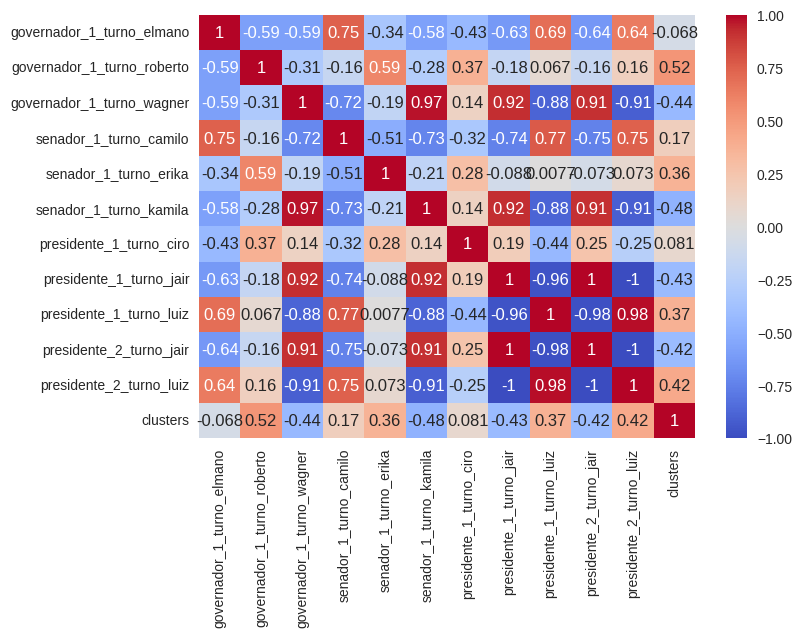

In [52]:
ax = sns.heatmap(data= dados_eleicao.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.show()

## 3.3 Redução de dimensionalidade com PCA

In [40]:
pca = PCA(n_components= 2)

In [41]:
dados_pca = pca.fit_transform(dados_eleicao.drop('nm_municipio', axis= 1))

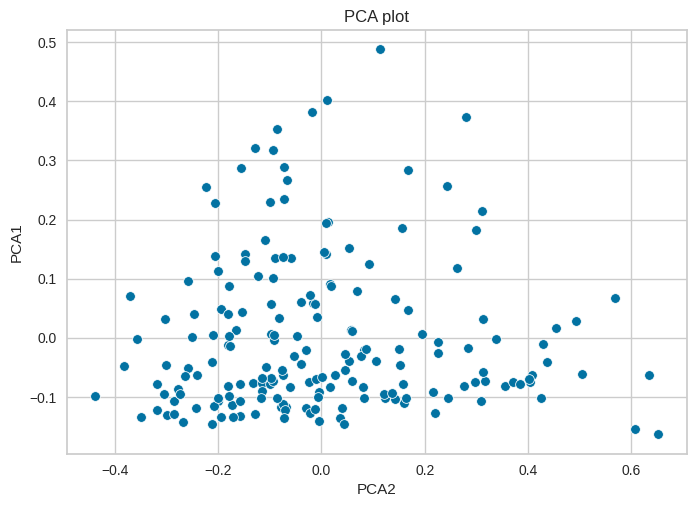

In [42]:
ax = sns.scatterplot(x= dados_pca[:, 0], y= dados_pca[:, 1])
ax.set_title('PCA plot')
ax.set_ylabel('PCA1')
ax.set_xlabel('PCA2')
plt.show()

In [43]:
pca.explained_variance_ratio_

array([0.67200915, 0.23190765])

## 5.3 Definição do número ideal de *clusters*

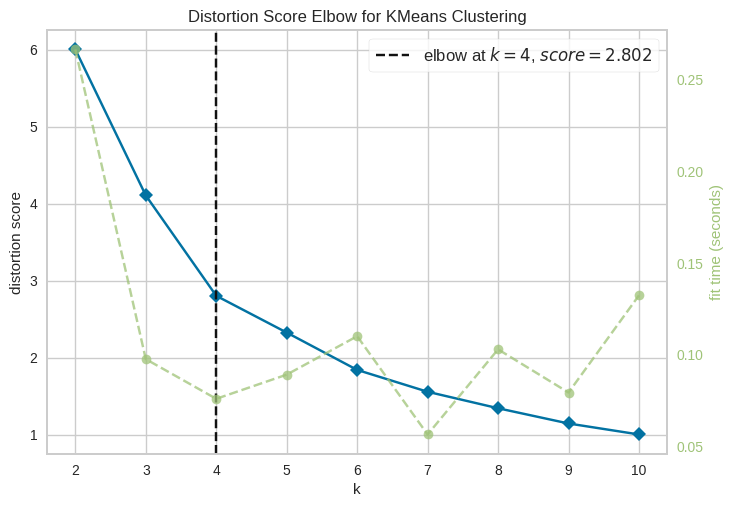

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [44]:
Elbow_M = KElbowVisualizer(KMeans(init= 'k-means++', max_iter= 300, n_init= 10, random_state= 42), k=10)
Elbow_M.fit(dados_pca)
Elbow_M.show()

In [45]:
kmeans = KMeans(n_clusters= 4, init= 'k-means++', max_iter= 300, n_init= 10, random_state= 0)

clusters = kmeans.fit_predict(dados_pca)

In [46]:
centroides = kmeans.cluster_centers_
centroides

array([[ 0.36902322, -0.0344509 ],
       [-0.22753061, -0.05351235],
       [ 0.01197229, -0.04747262],
       [-0.02970281,  0.23076449]])

In [47]:
classificacao = kmeans.labels_
classificacao

array([1, 0, 2, 3, 3, 3, 1, 1, 2, 1, 3, 0, 0, 2, 2, 1, 2, 3, 1, 2, 3, 3,
       2, 0, 1, 3, 2, 2, 2, 1, 3, 3, 1, 2, 2, 1, 2, 2, 1, 0, 0, 1, 1, 0,
       3, 1, 2, 2, 2, 2, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 3, 2, 1, 1, 1, 0,
       2, 2, 2, 2, 0, 2, 3, 2, 2, 2, 2, 2, 1, 1, 2, 1, 1, 1, 0, 2, 0, 2,
       2, 0, 1, 1, 2, 2, 0, 1, 3, 0, 2, 2, 3, 2, 1, 0, 0, 0, 1, 2, 2, 2,
       1, 3, 1, 1, 2, 3, 2, 2, 0, 1, 2, 1, 2, 1, 2, 3, 0, 0, 2, 1, 0, 2,
       0, 0, 2, 2, 1, 3, 2, 1, 2, 1, 3, 1, 3, 1, 1, 1, 0, 3, 3, 2, 2, 3,
       2, 1, 3, 3, 1, 1, 2, 2, 0, 1, 2, 0, 3, 2, 1, 2, 1, 3, 2, 0, 2, 2,
       0, 3, 3, 2, 2, 3, 2, 1], dtype=int32)

In [48]:
dados_eleicao['clusters'] = classificacao

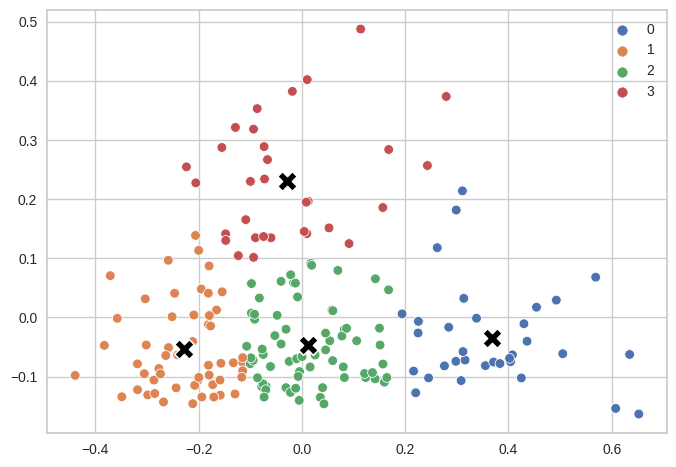

In [49]:
ax = sns.scatterplot(x= dados_pca[:, 0], y= dados_pca[:, 1], hue= classificacao, palette= 'deep')
sns.scatterplot(x= centroides[:, 0], y= centroides[:, 1], marker= 'X', s= 200, color= 'black')
plt.show()

<Axes: >

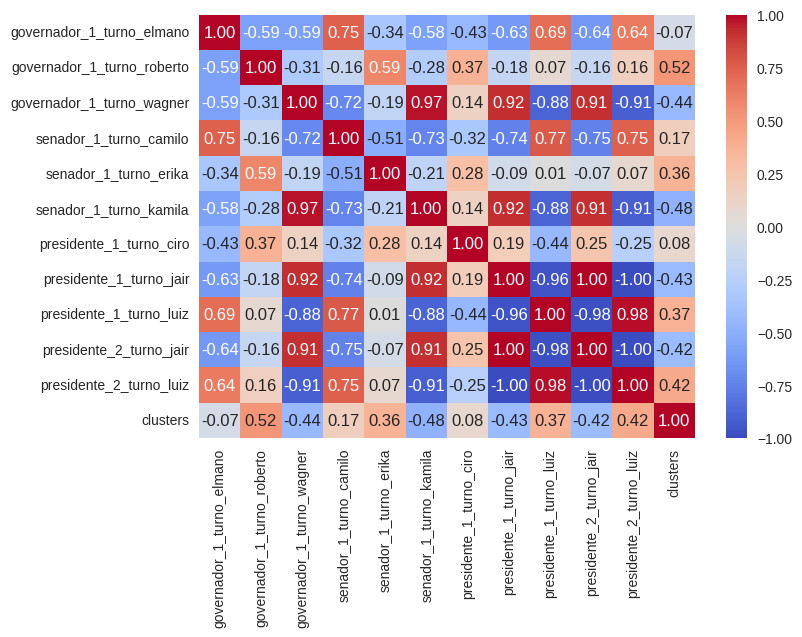

In [53]:
sns.heatmap(data= dados_eleicao.corr(numeric_only=True), annot=True, fmt='.2f', cmap='coolwarm')

<Axes: xlabel='presidente_1_turno_jair', ylabel='presidente_1_turno_luiz'>

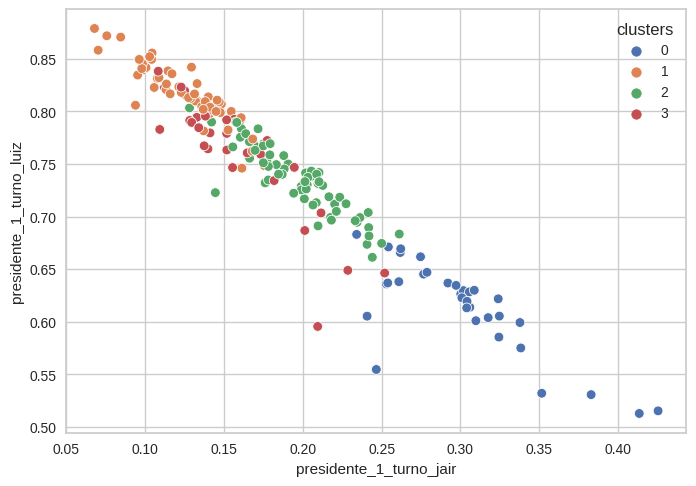

In [62]:
sns.scatterplot(data=dados_eleicao, x='presidente_1_turno_jair', y='presidente_1_turno_luiz', hue='clusters', palette='deep')

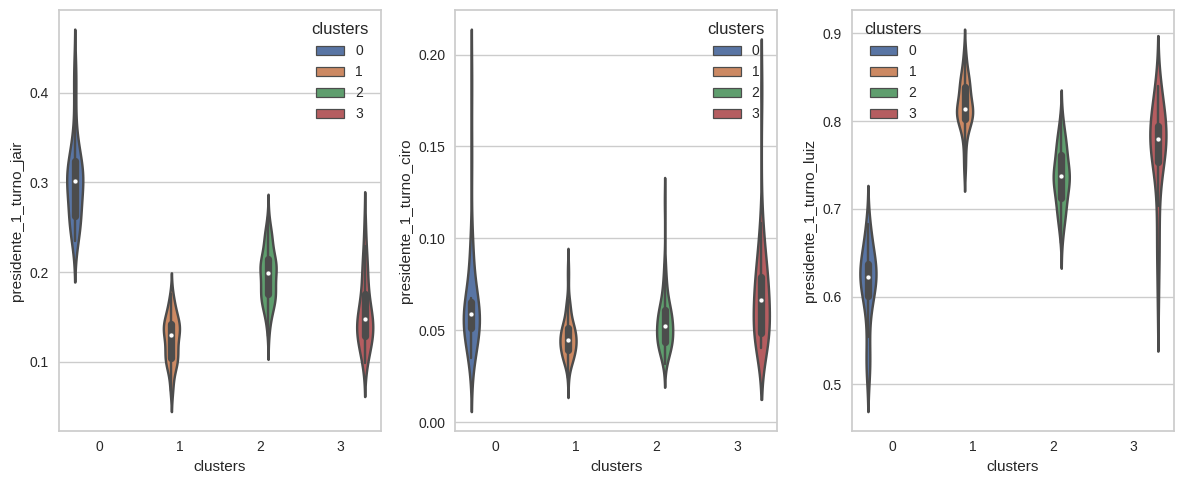

In [58]:
fig, ax = plt.subplots(1, 3, figsize= (12, 5))

ax1 = sns.violinplot(data=dados_eleicao, x='clusters', y='presidente_1_turno_jair', hue='clusters', palette='deep', ax=ax[0])
ax2 = sns.violinplot(data=dados_eleicao, x='clusters', y='presidente_1_turno_ciro', hue='clusters', palette='deep', ax=ax[1])
ax3 = sns.violinplot(data=dados_eleicao, x='clusters', y='presidente_1_turno_luiz', hue='clusters', palette='deep', ax=ax[2])
plt.tight_layout()
plt.show()

<Axes: xlabel='presidente_2_turno_jair', ylabel='presidente_2_turno_luiz'>

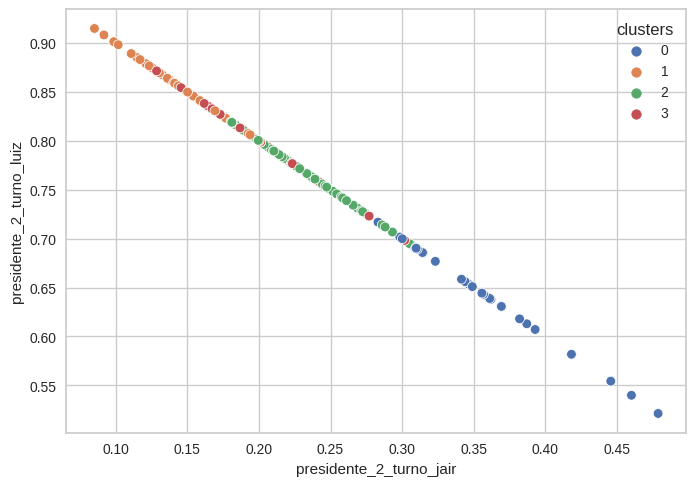

In [65]:
sns.scatterplot(data=dados_eleicao, x='presidente_2_turno_jair', y='presidente_2_turno_luiz', hue='clusters', palette='deep')

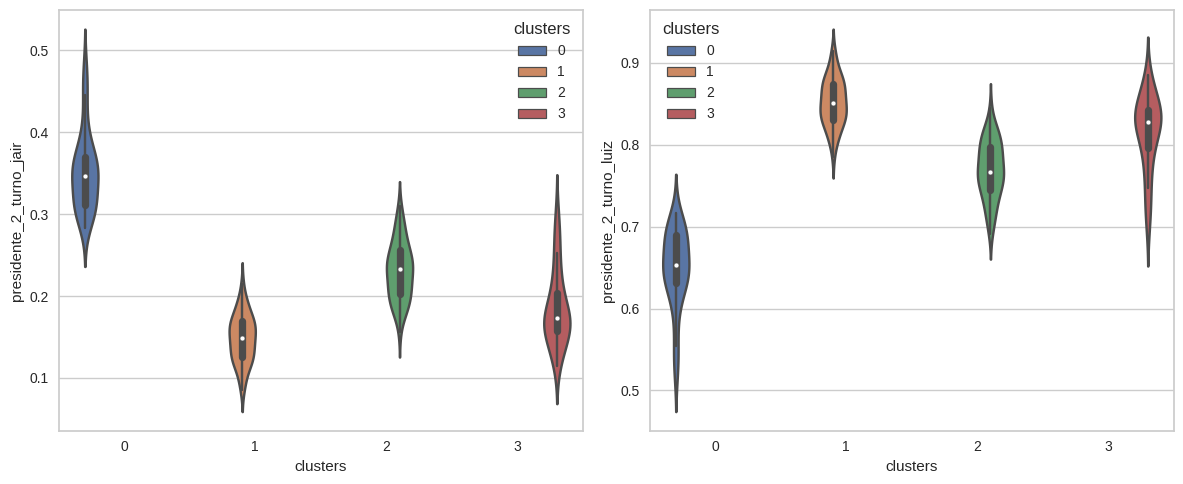

In [63]:
fig, ax = plt.subplots(1, 2, figsize= (12, 5))

ax1 = sns.violinplot(data=dados_eleicao, x='clusters', y='presidente_2_turno_jair', hue='clusters', palette='deep', ax=ax[0])
ax2 = sns.violinplot(data=dados_eleicao, x='clusters', y='presidente_2_turno_luiz', hue='clusters', palette='deep', ax=ax[1])
plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(2, 2)

ax1 = sns.scatterplot(data= dados_eleicao, x= 'presidente_1_turno_jair', y= 'presidente_1_turno_luiz', hue= 'clusters', palette= 'deep', ax= ax[0, 0])
ax2 = sns.scatterplot(data= dados_eleicao, x= 'presidente_1_turno_ciro', y= 'presidente_1_turno_jair', hue= 'clusters', palette= 'deep', ax= ax[0, 1])
ax3 = sns.scatterplot(data= dados_eleicao, x= 'presidente_1_turno_ciro', y= 'presidente_1_turno_luiz', hue= 'clusters', palette= 'deep', ax= ax[1, 0])
ax[1, 1].remove()
plt.tight_layout()
plt.show()

In [ ]:
sns.scatterplot(data= dados_eleicao, x= 'presidente_2_turno_jair', y= 'presidente_2_turno_luiz', hue= 'clusters', palette= 'deep')